In [8]:
import chess.pgn

games = open("lichess_db_standard_rated_2013-01.pgn", encoding="utf8", errors='ignore')

In [24]:
result = {}
i = 0
while True:
    i += 1
    game = chess.pgn.read_game(games)
    if game is None:
        break

    headers = dict(game.headers)
    headers["moves"] = game.board().variation_san(game.mainline_moves())
    headers["move_num"] = headers["moves"].count('.')

    result["Game{}".format(i)] = headers

In [25]:
import pandas as pd
results = pd.DataFrame(result)
df = results.transpose()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121332 entries, Game1 to Game121332
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Event            121332 non-null  object
 1   Site             121332 non-null  object
 2   Date             121332 non-null  object
 3   Round            121332 non-null  object
 4   White            121332 non-null  object
 5   Black            121332 non-null  object
 6   Result           121332 non-null  object
 7   BlackElo         121332 non-null  object
 8   BlackRatingDiff  121114 non-null  object
 9   ECO              121332 non-null  object
 10  Opening          121332 non-null  object
 11  Termination      121332 non-null  object
 12  TimeControl      121332 non-null  object
 13  UTCDate          121332 non-null  object
 14  UTCTime          121332 non-null  object
 15  WhiteElo         121332 non-null  object
 16  WhiteRatingDiff  121114 non-null  object
 17  moves  

In [26]:
import numpy as np

df['winner'] = np.where(df['Result'] == '1-0', 'white', 
                         np.where(df['Result'] == '0-1', 'black', 'draw'
                         ))
df.head()

,Event,Site,Date,Round,White,Black,Result,BlackElo,BlackRatingDiff,ECO,...,TimeControl,UTCDate,UTCTime,WhiteElo,WhiteRatingDiff,moves,move_num,BlackTitle,WhiteTitle,winner
Game1,Rated Classical game,https://lichess.org/j1dkb5dw,????.??.??,?,BFG9k,mamalak,1-0,1403,-8,C00,...,600+8,2012.12.31,23:01:03,1639,+5,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6...,13,NaN,NaN,white
Game2,Rated Classical game,https://lichess.org/a9tcp02g,????.??.??,?,Desmond_Wilson,savinka59,1-0,1919,-22,D04,...,480+2,2012.12.31,23:04:12,1654,+19,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nx...,18,NaN,NaN,white
Game3,Rated Classical game,https://lichess.org/szom2tog,????.??.??,?,Kozakmamay007,VanillaShamanilla,1-0,1747,-94,C50,...,420+17,2012.12.31,23:03:15,1643,+13,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Nc3 Bc5 5. a...,11,NaN,NaN,white
Game4,Rated Bullet game,https://lichess.org/rklpc7mk,????.??.??,?,Naitero_Nagasaki,800,0-1,1973,+8,B12,...,60+1,2012.12.31,23:04:57,1824,-6,1. e4 c6 2. Nc3 d5 3. Qf3 dxe4 4. Nxe4 Nd7 5. ...,47,NaN,NaN,black
Game5,Rated Bullet game,https://lichess.org/1xb3os63,????.??.??,?,nichiren1967,Naitero_Nagasaki,0-1,1815,+9,C00,...,60+1,2012.12.31,23:02:37,1765,-9,1. e4 e6 2. f4 d5 3. e5 c5 4. Nf3 Qb6 5. c3 Nc...,23,NaN,NaN,black


In [27]:
chessdf = df[df['winner']!='draw']
chessdf.head()

,Event,Site,Date,Round,White,Black,Result,BlackElo,BlackRatingDiff,ECO,...,TimeControl,UTCDate,UTCTime,WhiteElo,WhiteRatingDiff,moves,move_num,BlackTitle,WhiteTitle,winner
Game1,Rated Classical game,https://lichess.org/j1dkb5dw,????.??.??,?,BFG9k,mamalak,1-0,1403,-8,C00,...,600+8,2012.12.31,23:01:03,1639,+5,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6...,13,NaN,NaN,white
Game2,Rated Classical game,https://lichess.org/a9tcp02g,????.??.??,?,Desmond_Wilson,savinka59,1-0,1919,-22,D04,...,480+2,2012.12.31,23:04:12,1654,+19,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nx...,18,NaN,NaN,white
Game3,Rated Classical game,https://lichess.org/szom2tog,????.??.??,?,Kozakmamay007,VanillaShamanilla,1-0,1747,-94,C50,...,420+17,2012.12.31,23:03:15,1643,+13,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Nc3 Bc5 5. a...,11,NaN,NaN,white
Game4,Rated Bullet game,https://lichess.org/rklpc7mk,????.??.??,?,Naitero_Nagasaki,800,0-1,1973,+8,B12,...,60+1,2012.12.31,23:04:57,1824,-6,1. e4 c6 2. Nc3 d5 3. Qf3 dxe4 4. Nxe4 Nd7 5. ...,47,NaN,NaN,black
Game5,Rated Bullet game,https://lichess.org/1xb3os63,????.??.??,?,nichiren1967,Naitero_Nagasaki,0-1,1815,+9,C00,...,60+1,2012.12.31,23:02:37,1765,-9,1. e4 e6 2. f4 d5 3. e5 c5 4. Nf3 Qb6 5. c3 Nc...,23,NaN,NaN,black


In [28]:
import pickle

with open('chess_data.pickle', 'wb') as to_write:
        pickle.dump(chessdf, to_write)

In [1]:
import pickle

with open('chess_data.pickle','rb') as read_file:
    chess_df = pickle.load(read_file)



chess_df = chess_df.iloc[0:20000]
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, Game1 to Game20658
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Event            20000 non-null  object
 1   Site             20000 non-null  object
 2   Date             20000 non-null  object
 3   Round            20000 non-null  object
 4   White            20000 non-null  object
 5   Black            20000 non-null  object
 6   Result           20000 non-null  object
 7   BlackElo         20000 non-null  object
 8   BlackRatingDiff  19961 non-null  object
 9   ECO              20000 non-null  object
 10  Opening          20000 non-null  object
 11  Termination      20000 non-null  object
 12  TimeControl      20000 non-null  object
 13  UTCDate          20000 non-null  object
 14  UTCTime          20000 non-null  object
 15  WhiteElo         20000 non-null  object
 16  WhiteRatingDiff  19961 non-null  object
 17  moves            20000 non-n

In [2]:
moves = chess_df['moves']
winner = chess_df['winner']
move_num = chess_df['move_num']
X = []
y = []

In [3]:
max(move_num)

125

In [4]:
import numpy as np
import pandas as pd
import chess
moves_array = pd.array(moves, dtype="string")
type(moves_array)

pandas.core.arrays.string_.StringArray

In [5]:
char_list = []
for i in range(1,500):
    char_list.append(str(i) + '.')


In [6]:
def make_matrix(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo
def translate(matrix,chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}

In [7]:
for game in moves:
    index = list(moves).index(game)
    allmoves = game.split()
    all_moves = [elem for elem in allmoves if elem not in char_list] 
    total_moves = len(all_moves)
    if winner[index] == 'black':
        game_winner = -1
    else:
        game_winner = 1
    board = chess.Board()
    for i in range(len(all_moves)):
        board.push_san(all_moves[i])
        value = game_winner * (i/total_moves)
        matrix = make_matrix(board.copy())
        rows = translate(matrix,chess_dict)
        X.append([rows])
        y.append(value)
X = np.array(X).reshape(len(X),8,8,12)
y = np.array(y)
X.shape

(1287087, 8, 8, 12)

In [8]:
from keras import callbacks, optimizers
from keras.layers import (LSTM, BatchNormalization, Dense, Dropout, Flatten,
                          TimeDistributed)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, model_from_json
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=1, activation='relu', input_shape=(8,8,12)))
model.add(MaxPooling2D())
model.add(Conv2D(filters=24, kernel_size=1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=10, kernel_size=1, activation='relu'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1,activation = 'tanh'))
model.predict(X)

array([[-0.3664953 ],
       [-0.37351638],
       [-0.3755861 ],
       ...,
       [-0.1367787 ],
       [-0.11345964],
       [-0.16878039]], dtype=float32)

Training Network...
Epoch 1/10
40222/40222 - 105s - loss: 0.3279
Epoch 2/10
40222/40222 - 108s - loss: 0.3255
Epoch 3/10
40222/40222 - 112s - loss: 0.3255
Epoch 4/10
40222/40222 - 108s - loss: 0.3252
Epoch 5/10
40222/40222 - 105s - loss: 0.3209
Epoch 6/10
40222/40222 - 107s - loss: 0.3137
Epoch 7/10
40222/40222 - 105s - loss: 0.3107
Epoch 8/10
40222/40222 - 105s - loss: 0.3093
Epoch 9/10
40222/40222 - 105s - loss: 0.3059
Epoch 10/10
40222/40222 - 103s - loss: 0.2903


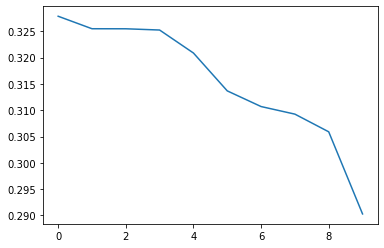

In [17]:
from matplotlib import pyplot as plt
model.compile(optimizer='Nadam', loss='mse')
#dirx = 'C:\\Users\\v_sim\\Desktop\\Files\\Programs\\ML\\Best Models'
#os.chdir(dirx)
h5 = 'chess' + '_best_model' + '.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                           monitor='loss',
                                           verbose=0,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=1)
es = callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5000/10)
callback = [checkpoint,es]
json = 'chess' + '_best_model' + '.json'
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
print('Training Network...')
history = model.fit(X,y,epochs = 10,verbose = 2,callbacks = callback)
plt.plot(history.history['loss'])


In [9]:
from matplotlib import pyplot as plt
model.compile(optimizer='Nadam', loss='mse')
#dirx = 'C:\\Users\\v_sim\\Desktop\\Files\\Programs\\ML\\Best Models'
#os.chdir(dirx)
h5 = 'chess' + '_best_model' + '.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                           monitor='loss',
                                           verbose=0,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=1)
es = callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5000/10)
callback = [checkpoint,es]
json = 'chess' + '_best_model' + '.json'
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
print('Training Network...')
history = model.fit(X,y,epochs = 25,verbose = 2,callbacks = callback)
plt.plot(history.history['loss'])

Training Network...
Epoch 1/25
40222/40222 - 1448s - loss: 0.3279
Epoch 2/25
40222/40222 - 4104s - loss: 0.3255
Epoch 3/25


KeyboardInterrupt: 

In [19]:
randint1 = np.random.randint(1,len(moves))
randint2 = np.random.randint(1,len(all_moves[randint]))
board = chess.Board()
for i in range(randint2):
    board.push_san(all_moves[randint][i])
matrix = make_matrix(board.copy())
rows = translate(matrix,chess_dict)
print('Board Evaluation:',model.predict([rows])[0][0])
board

IndexError: list index out of range

In [ ]:
randint = np.random.randint(1,len(moves))
randint2 = np.random.randint(1,len(moves[randint].split()))
board = chess.Board()
for i in range(randint2):
    board.push_san(moves[randint].split()[i])
matrix = make_matrix(board.copy())
rows = translate(matrix,chess_dict)
print('Board Evaluation:',model.predict([rows])[0][0])
board